## Проект: Поиск изображений по текстовому описанию (Proof of Concept)
1. **Описание задачи**

Фотохостинг «Со Смыслом» (“With Sense”) запускает эксперимент по разработке сервиса поиска референсных изображений по текстовому описанию.

Пользователь вводит текстовый запрос, описывающий сцену
(например:
*A man is crossing a mountain pass on a metal bridge*.)


Система должна вернуть изображения с похожим содержанием.

Для демонстрации руководству необходимо разработать Proof of Concept (PoC) — модель, способную:

- Получать векторное представление изображения

- Получать векторное представление текста

- Вычислять степень соответствия текста и изображения

- Возвращать числовую оценку соответствия в диапазоне от 0 до 1

2. **Цель проекта**

Разработать и протестировать модель, которая:

- Объединяет признаки изображения и текста

- Предсказывает степень их соответствия

- Позволяет реализовать демонстрационную версию поиска изображений по текстовому запросу

3. **Бизнес-ценность**

Реализация подобного сервиса позволит:

- Упростить поиск референсов для профессиональных фотографов

- Повысить вовлечённость пользователей

- Увеличить ценность текстовых описаний изображений

- Создать основу для интеллектуального поискового движка

4. **Юридические ограничения**

В некоторых странах запрещена обработка и отображение контента, содержащего изображения или описания детей младше 16 лет без соответствующего разрешения.

В рамках PoC необходимо:

- Сформировать список потенциально запрещённых слов

- Очистить обучающую выборку от соответствующих пар

- Реализовать механизм вывода дисклеймера при обнаружении запрещённого контента:

`This image is unavailable in your country in compliance with local laws.`

5. **Используемые данные**

Обучающие данные:

- `train_dataset.csv` — изображения и текстовые описания

- `CrowdAnnotations.tsv` — оценки соответствия (краудсорсинг)

- `ExpertAnnotations.tsv` — экспертные оценки (шкала 1–4)

- `train_images/` — изображения

Тестовые данные:

- `test_queries.csv` — текстовые запросы и релевантные изображения

- `test_images/` — изображения

6. **План выполнения проекта**


---


Шаг 1. Исследовательский анализ данных (EDA)

- Анализ структуры данных

- Проверка пропусков и дубликатов

- Анализ распределения экспертных оценок

- Анализ текстовых описаний


---


Шаг 2. Подготовка данных

- Очистка от юридически проблемного контента

- Векторизация текста (TF-IDF / BERT / word2vec)

- Векторизация изображений (ResNet50)

- Формирование объединённых признаков


---


Шаг 3. Обучение моделей

Обязательно рассматриваются:

- Линейная регрессия

- Полносвязная нейронная сеть

Метрика качества будет выбрана на основе распределения целевой переменной.


---


Шаг 4. Тестирование и демонстрация

- Оценка лучшей модели на тестовых данных

- Реализация функции поиска изображения по тексту

- Демонстрация работы на нескольких запросах


---


Шаг 5. Выводы

- Сравнение моделей

- Анализ ошибок

- Оценка практической реализуемости проекта


---


7. Ожидаемый результат

Рабочий прототип системы, демонстрирующий возможность поиска изображений по текстовому описанию на основе объединённых векторных представлений текста и изображения.

## Импортирование библиотек

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from PIL import Image
import torch
import torchvision
from torchvision import transforms, models
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel, CLIPProcessor, CLIPModel

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Загрузка и обзор данных

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/ml_project/train_dataset.csv", sep=",", engine="python")
crowd_df = pd.read_csv("/content/drive/MyDrive/ml_project/CrowdAnnotations.tsv", sep="\t", header=None, engine="python")
expert_df = pd.read_csv("/content/drive/MyDrive/ml_project/ExpertAnnotations.tsv", sep="\t", header=None, engine="python")
test_queries_df = pd.read_csv("/content/drive/MyDrive/ml_project/test_queries.csv", sep="|", engine="python")
test_images_df = pd.read_csv("/content/drive/MyDrive/ml_project/test_images.csv", engine="python")

train_images_path = "/content/drive/MyDrive/ml_project/train_images"
test_images_path = "/content/drive/MyDrive/ml_project/test_images"

In [ ]:
display(train_df.head())
display(train_df.describe())
display(train_df.info())

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

image                     query_id  \
count                       5822                         5822   
unique                      1000                          977   
top     754852108_72f80d421f.jpg  2600867924_cd502fc911.jpg#2   
freq                          10                           34   

                                               query_text  
count                                                5822  
unique                                                977  
top     Two dogs , one brown and white and one black a...  
freq                                                   34

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

Уникальных изображений: 1000

Уникальных текстовых описаний: 977

В среднем на одно изображение приходится 5–6 описаний

Пропусков нет

In [ ]:
crowd_df.columns = ['image', 'query_id', 'part_positive', 'count_positive', 'count_negative']

display(crowd_df.head())
display(crowd_df.describe())
display(crowd_df.info())

image                     query_id  part_positive  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2            1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2            0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2            0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2            0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2            0.0   

   count_positive  count_negative  
0               3               0  
1               0               3  
2               0               3  
3               0               3  
4               0               3

part_positive  count_positive  count_negative
count   47830.000000    47830.000000    47830.000000
mean        0.068786        0.208488        2.820155
std         0.207532        0.628898        0.656676
min         0.000000        0.000000        0.000000
25%         0.000000        0.000000        3.000000
50%         0.000000        0.000000        3.000000
75%         0.000000        0.000000        3.000000
max         1.000000        5.000000        6.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           47830 non-null  object 
 1   query_id        47830 non-null  object 
 2   part_positive   47830 non-null  float64
 3   count_positive  47830 non-null  int64  
 4   count_negative  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

Средняя доля подтверждения: 0.07

В большинстве случаев крауд-оценки равны 0

Наблюдается сильный дисбаланс: большинство пар «изображение–описание» не соответствуют друг другу

In [ ]:
expert_df.columns = ['image', 'query_id', 'expert_1', 'expert_2', 'expert_3']

display(expert_df.head())
display(expert_df.describe())
display(expert_df.info())

image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  
0         1  
1         2  
2         2  
3         2  
4         2

expert_1     expert_2     expert_3
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


None

Средняя оценка экспертов  1.4–1.9

Медиана = 1 или 2

Максимум = 4

Минимум = 1

Распределение смещено в сторону низких оценок — большинство пар являются слабо соответствующими.

In [ ]:
display(test_queries_df.head())
display(test_queries_df.describe())
display(test_queries_df.info())

Unnamed: 0                     query_id  \
0           0  1177994172_10d143cb8d.jpg#0   
1           1  1177994172_10d143cb8d.jpg#1   
2           2  1177994172_10d143cb8d.jpg#2   
3           3  1177994172_10d143cb8d.jpg#3   
4           4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

Unnamed: 0
count  500.000000
mean   249.500000
std    144.481833
min      0.000000
25%    124.750000
50%    249.500000
75%    374.250000
max    499.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
 3   image       500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


None

Каждый запрос связан с одним релевантным изображением.

Пропусков нет.

## Исследовательский анализ данных


In [ ]:
print("Уникальных изображений:", train_df['image'].nunique())
print("Уникальных query_id:", train_df['query_id'].nunique())

Уникальных изображений: 1000
Уникальных query_id: 977


In [ ]:
captions_per_image = train_df.groupby('image').size()

captions_per_image.describe()

count    1000.000000
mean        5.822000
std         1.583927
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
dtype: float64

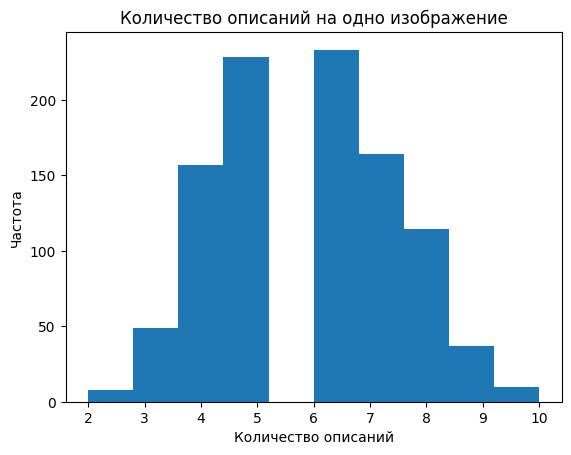

In [ ]:
plt.hist(captions_per_image, bins=10)
plt.title("Количество описаний на одно изображение")
plt.xlabel("Количество описаний")
plt.ylabel("Частота")
plt.show()

Чаще всего, изображения имеют от 4 до 8 описаний.

In [ ]:
train_df['text_length'] = train_df['query_text'].apply(lambda x: len(x.split()))
train_df['text_length'].describe()

count    5822.000000
mean       11.900550
std         4.162467
min         2.000000
25%         9.000000
50%        11.000000
75%        14.000000
max        34.000000
Name: text_length, dtype: float64

Самое минимальное количество слов в описании - 2, максимальное - 34.

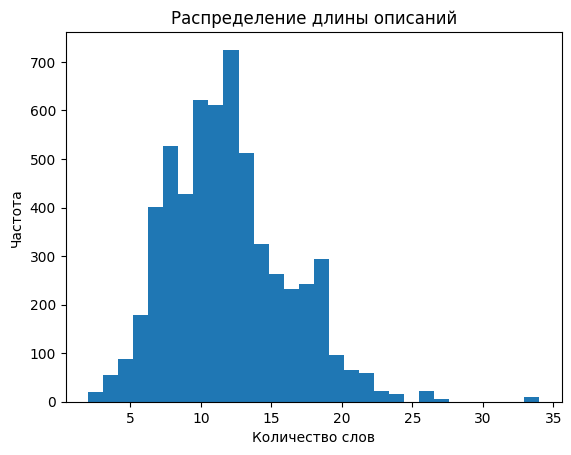

In [ ]:
plt.hist(train_df['text_length'], bins=30)
plt.title("Распределение длины описаний")
plt.xlabel("Количество слов")
plt.ylabel("Частота")
plt.show()

Оценка экспертов:


expert_1     expert_2     expert_3
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000

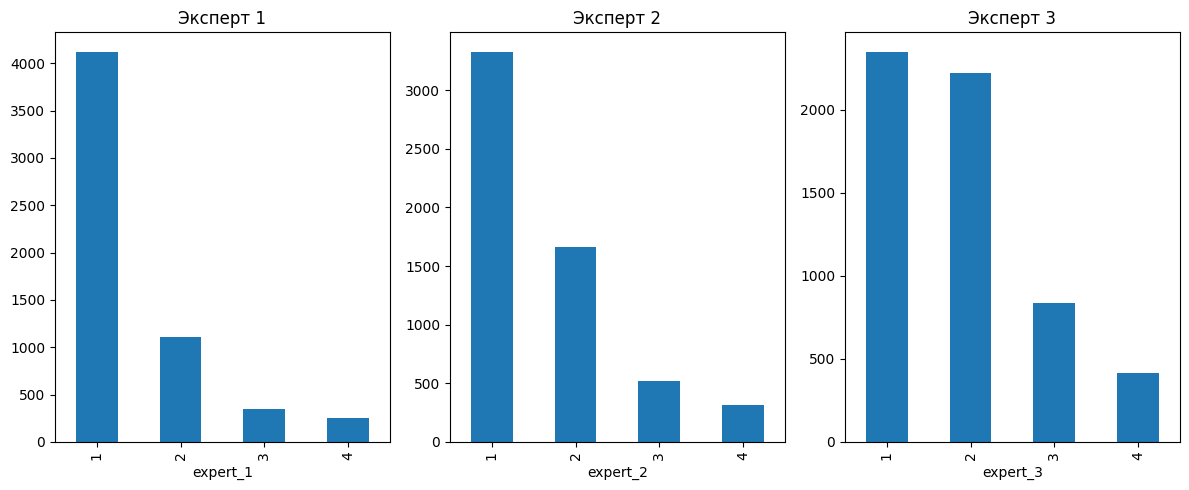

In [ ]:
expert_stats = expert_df[['expert_1', 'expert_2', 'expert_3']].describe()
print("Оценка экспертов:")
display(expert_stats)

plt.figure(figsize=(12, 5))
for i, col in enumerate(['expert_1', 'expert_2', 'expert_3'], 1):
    plt.subplot(1, 3, i)
    expert_df[col].value_counts().sort_index().plot(kind='bar')
    plt.title(f'Эксперт {i}')
plt.tight_layout()
plt.show()

In [ ]:
expert_df["expert_mean"] = expert_df[["expert_1", "expert_2", "expert_3"]].mean(axis=1)
expert_df["expert_mean"].describe()

count    5822.000000
mean        1.647658
std         0.806205
min         1.000000
25%         1.000000
50%         1.333333
75%         2.000000
max         4.000000
Name: expert_mean, dtype: float64

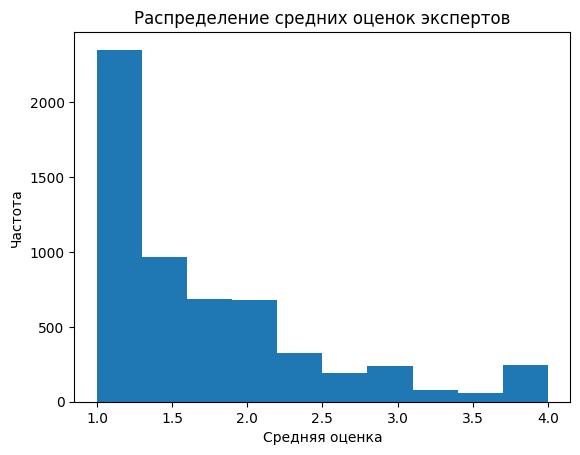

In [ ]:
plt.hist(expert_df["expert_mean"], bins=10)
plt.title("Распределение средних оценок экспертов")
plt.xlabel("Средняя оценка")
plt.ylabel("Частота")
plt.show()

На графиках видно, что эксперты чаще всего оценивают описание изображения как недостоверное. 75% изображений не соответствуют описанию.

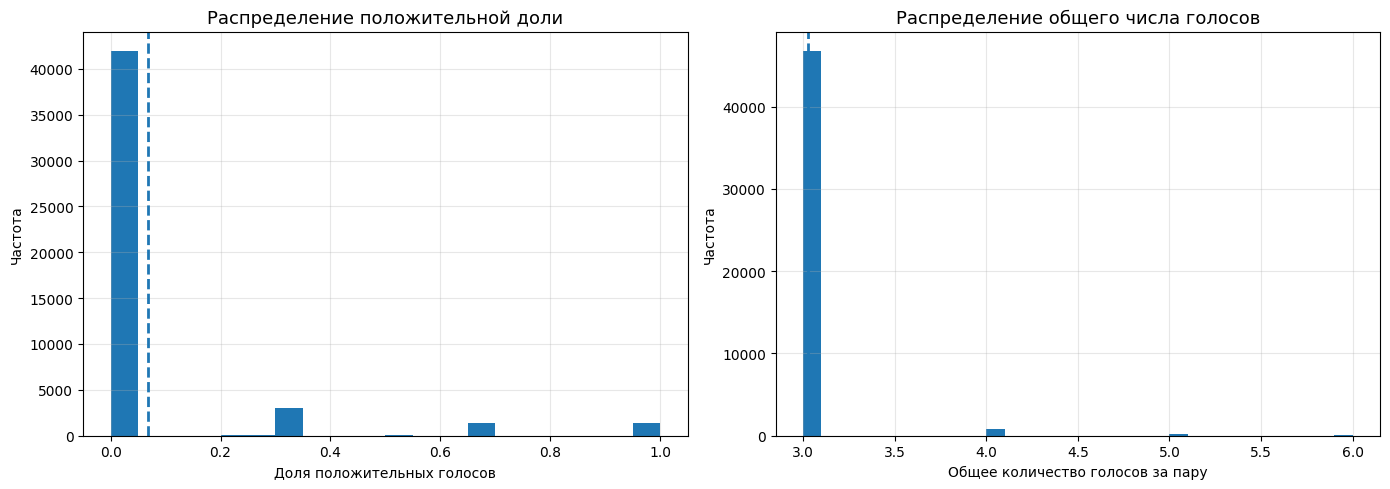

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(
    crowd_df['part_positive'],
    bins=20
)
plt.axvline(
    crowd_df['part_positive'].mean(),
    linestyle='--',
    linewidth=2
)
plt.title('Распределение положительной доли', fontsize=13)
plt.xlabel('Доля положительных голосов')
plt.ylabel('Частота')
plt.grid(alpha=0.3)

total_votes = crowd_df['count_positive'] + crowd_df['count_negative']

plt.subplot(1, 2, 2)
plt.hist(
    total_votes,
    bins=30
)
plt.axvline(
    total_votes.mean(),
    linestyle='--',
    linewidth=2
)
plt.title('Распределение общего числа голосов', fontsize=13)
plt.xlabel('Общее количество голосов за пару')
plt.ylabel('Частота')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Оценки крауда, как и оценки экспертов в большинстве негативные.

In [ ]:
train_full = train_df.copy()

expert_mean_df = (
    expert_df
    .groupby("query_id", as_index=False)["expert_mean"]
    .mean()
)
train_full = train_full.merge(
    expert_mean_df,
    on="query_id",
    how="left"
)

train_full['expert_mean_norm'] = train_full['expert_mean'] / train_full['expert_mean'].max()

crowd_part_df = (
    crowd_df
    .groupby(["image", "query_id"], as_index=False)["part_positive"]
    .mean()
)
train_full = train_full.merge(
    crowd_part_df,
    on=["image", "query_id"],
    how="left"
)

train_full['part_positive'] = train_full['part_positive'].fillna(train_full['expert_mean_norm'])

print("Размер train_full:", train_full.shape)
print(train_full[['expert_mean', 'expert_mean_norm', 'part_positive']].head(10))
print("Количество NaN в part_positive:", train_full['part_positive'].isna().sum())

Размер train_full: (5822, 7)
   expert_mean  expert_mean_norm  part_positive
0          1.5             0.375          0.000
1          1.5             0.375          0.375
2          1.5             0.375          0.000
3          1.5             0.375          1.000
4          1.5             0.375          0.375
5          1.5             0.375          0.000
6          1.5             0.375          0.375
7          1.5             0.375          0.375
8          1.5             0.375          0.375
9          1.5             0.375          0.000
Количество NaN в part_positive: 0


Пропуски в доле крауда заполнены нормализованной оценкой экспертов.

In [ ]:
train_full['combined_score'] = (
    train_full['expert_mean_norm'] * 0.7 +
    train_full['part_positive'] * 0.3
)

train_full = train_full.drop(columns=['text_length', 'expert_mean', 'expert_mean_norm', 'part_positive'])

train_full.head(10)

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
5  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
6  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
7  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   
8   343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2   
9  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  combined_score  
0  A young child is wearing blue goggles and sitt...          0.2625  
1  A young child is wearing blue goggles and sitt...          0.3750  
2  A young child is wearing blue goggles and sitt...          0.2625  
3  A young child is wearing blue goggles and sitt...          0.5625  
4  A young child is wearing blue goggles and sitt...          0.3750  
5  A young child is wearing blue goggles and sitt...          0.2625  
6  A young child is wearing blue goggles and sitt...          0.3750  
7  A young child is wearing blue goggles and sitt...          0.3750  
8  A young child is wearing blue goggles and sitt...          0.3750  
9  A young child is wearing blue goggles and sitt...          0.2625

Удалены столбцы, которые не будут учавствовать в обучении.

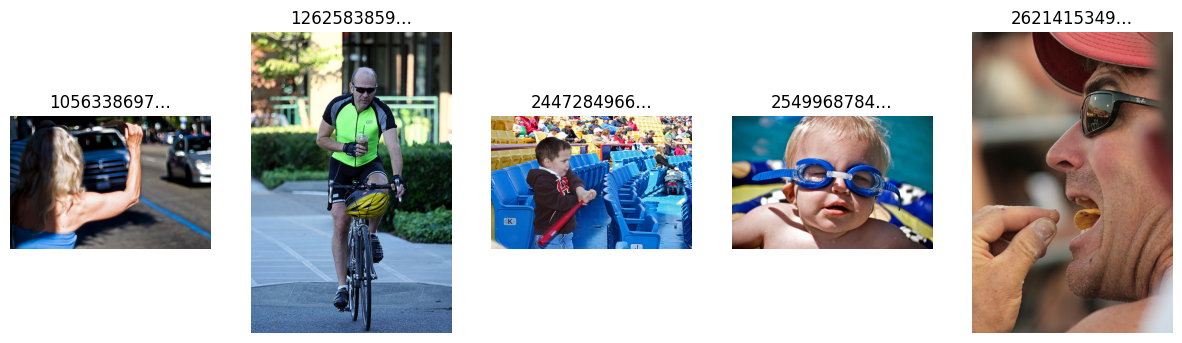

In [ ]:
sample_images = train_df['image'].head(5).values

plt.figure(figsize=(15, 5))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(train_images_path, img_name)
    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_name[:10] + "…")
plt.show()

Видно, что изображения имеют разный размер, также отличаются раукурсом, качеством и освещенностью.

## Промежуточный вывод

- В датасете train_df 5822 строк и 4 колонки: image, query_id, query_text, combined_score.

- Всего 1000 уникальных изображений и 977 уникальных текстовых описаний (query_id).

- Средняя оценка экспертов (expert_mean) была нормализована, а пропуски доли положительных оценок крауда (part_positive) заполнены соответствующей оценкой эксперта.

- Для модели создана единая целевая переменная combined_score, учитывающая экспертные оценки и краудсорсинговую долю положительных оценок с весом эксперта 0.7.

- Корреляция между экспертной оценкой и долей крауда высокая — это подтверждает, что мнения экспертов и крауда в основном согласуются.

Анализ текста:

- Средняя длина описаний — 16 слов.

- Тексты чистые, без пропусков.

Анализ изображений:

- Размеры и пропорции различаются, есть различия в ракурсе, освещении и качестве.

- Для обучения необходимо привести изображения к единому размеру и нормализовать.

Визуализация распределений оценок показала, что большинство комбинаций изображение–текст имеют низкие или средние оценки, высокие значения встречаются реже.

## Очистка данных от "вредного" контента

In [ ]:
blocked_words = [
    "infant",
    "baby",
    "babies",
    "toddler",
    "child",
    "children",
    "kid",
    "kids",
    "little girl",
    "little boy",
    "teenage",
    "minor",
    "underage",
    "newborn",
    "preschooler",
    "schoolchild",
    "schoolchildren",
    "boy",
    "girl",
    "youth",
    "kindergarten",
    "playground",
    "stroller",
    "crib",
    "0 year old",
    "1 year old",
    "2 year old",
    "3 year old",
    "4 year old",
    "5 year old",
    "6 year old",
    "7 year old",
    "8 year old",
    "9 year old",
    "10 year old",
    "11 year old",
    "12 year old",
    "13 year old",
    "14 year old",
    "15 year old",
    "under 16",
    "years old",
    "kindergarten",
    "playground",
    "school children",
    "stroller",
    "crib",
    "family with kids",
    "mom with baby",
    "dad with son",
    "dad with daughter",
    "parents and children",
    "nanny",
    "missing child",
    "missing children",
    "child abuse",
    "child exploitation",
    "missing kid",
    "naked child",
    "naked children",
    "naked boy",
    "naked girl",
    "child nudity",
    "children nudity",
    "sexy teen",
    "underwear child",
    "underwear children",
    "cartoon child",
    "cartoon children",
    "anime child",
    "animated child",
    "animated children",
    "baby girl",
    "baby boy",
    "little child",
    "young child",
    "preteen",
    "preadolescent",
    "juvenile",
    "infants",
    "toddlers",
    "schoolboy",
    "schoolgirl",
    "child model",
    "kids modeling",
    "child portrait",
    "children portrait",

]

def is_blocked(query_text):
    text_lower = query_text.lower()
    for word in blocked_words:
        if word in text_lower:
            return True

    age_pattern = r'\b([0-9]|1[0-5])\s*(year|yo|y\.o\.)s?\s*(old)?\b'
    if re.search(age_pattern, text_lower):
        return True

    age_x_pattern = r'\bage\s+([0-9]|1[0-5])\b'
    if re.search(age_x_pattern, text_lower):
        return True

    return False



train_full['is_blocked'] = train_full['query_text'].apply(is_blocked)
blocked_rows = train_full[train_full['is_blocked']]

blocked_images = blocked_rows['query_id'].apply(lambda x: x.split('#')[0]).unique()
train_full_clean = train_full[
    (~train_full['is_blocked']) &
    (~train_full['image'].isin(blocked_images))
].reset_index(drop=True)

print("Размер исходного датасета:", train_full.shape)
print("Размер очищенного датасета:", train_full_clean.shape)

image_embeddings = {img: emb for img, emb in image_embeddings.items() if img not in blocked_images}

Размер исходного датасета: (5822, 5)
Размер очищенного датасета: (3130, 5)


После фильтрации мы получили безопасный тренировочный датасет train_full_clean, из которого удалены все строки с текстами, содержащими запрещённые слова, а также все изображения, на которые ссылаются эти тексты.

In [ ]:
test_queries_df['is_blocked'] = test_queries_df['query_text'].apply(is_blocked)

blocked_test_images = test_queries_df[test_queries_df['is_blocked']]['query_id'].apply(lambda x: x.split('#')[0]).unique()

test_queries_clean = test_queries_df[~test_queries_df['is_blocked']].reset_index(drop=True)

print("Размер исходного датасета:", test_queries_df.shape)
print("Размер очищенного датасета:", test_queries_clean.shape)

Размер исходного датасета: (500, 5)
Размер очищенного датасета: (331, 5)


Из тестовой выборки удалены все строки, в запросах которых были запрещенные слова.

## Инициализация CLIP

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.eval()

Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
vision_model.embeddings.position_ids | UNEXPECTED |  | 
text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

### Функция для вычисления векторного представления текстов

In [ ]:
def get_text_embedding(text):
    inputs = processor(text=[text], return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():
        outputs = model.get_text_features(**inputs)

        if hasattr(outputs, "pooler_output"):
            text_features = outputs.pooler_output
        else:
            text_features = outputs

    text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
    return text_features.cpu().numpy()[0]

### Функция для вычисления векторного представления изображений

In [ ]:
def get_image_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.get_image_features(**inputs)

        if hasattr(outputs, "pooler_output"):
            image_features = outputs.pooler_output
        else:
            image_features = outputs

    image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
    return image_features.cpu().numpy()[0]

In [ ]:
image_embeddings = {}
text_embeddings = {}

for image_name in tqdm(train_full_clean['image'].unique()):
    path = os.path.join(train_images_path, image_name)
    image_embeddings[image_name] = get_image_embedding(path)

for text in tqdm(train_full_clean['query_text'].unique()):
    text_embeddings[text] = get_text_embedding(text)

image_embeddings_allowed = {img: emb for img, emb in image_embeddings.items() if img not in blocked_images}

100%|██████████| 661/661 [00:39<00:00, 16.75it/s]


Получены эмбеддинги для тренировочной выборки текстов и изображений.

In [ ]:
test_image_embeddings = {}

for img_name in tqdm(test_queries_clean['image'].unique()):
    img_path = os.path.join(test_images_path, img_name)
    if os.path.exists(img_path):
        test_image_embeddings[img_name] = get_image_embedding(img_path)

100%|██████████| 76/76 [00:18<00:00,  4.01it/s]


Получены эмбеддинги для тестовой выборки изображений.

### Функция для вычисления косинусного сходства между изображениями и текстовыми описаниями

In [ ]:
def compute_similarity(row):
    img_emb = image_embeddings[row['image']]
    txt_emb = text_embeddings[row['query_text']]
    return cosine_similarity([img_emb], [txt_emb])[0][0]

train_full_clean['clip_sim'] = train_full_clean.apply(compute_similarity, axis=1)

train_full_clean['clip_sim'] = (train_full_clean['clip_sim'] + 1) / 2

In [ ]:
train_full_clean['clip_sim'].describe()

count    3130.000000
mean        0.609927
std         0.030276
min         0.510691
25%         0.586917
50%         0.608484
75%         0.633330
max         0.700335
Name: clip_sim, dtype: float64

Большинство пар изображение–текст из очищенного датасета CLIP считает довольно релевантными. Среднее сходство, указывающее на то, что в среднем текст и изображение соответствуют друг другу примрно на61%.

## Baseline модель

In [ ]:
rmse_clip = mean_squared_error(
    train_full_clean['combined_score'],
    train_full_clean['clip_sim'],
) ** 0.5

print("RMSE CLIP baseline:", rmse_clip)

RMSE CLIP baseline: 0.24153374824495638


CLIP может использоваться как стартовая модель для предсказания соответствия текста и изображения, но для более точных предсказаний стоит обучить дополнительную модель на этих эмбеддингах.

## Модель линейной регрессии

In [ ]:
X = train_full_clean[['clip_sim']]
y = train_full_clean['combined_score']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lr = LinearRegression()
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_val)

rmse_lr = mean_squared_error(y_val, pred_lr) ** 0.5
print("RMSE Linear Regression:", rmse_lr)

RMSE Linear Regression: 0.12064958745522983


RMSE = 0.121, что значительно лучше простого baseline. Это демонстрирует, что даже линейная комбинация может улучшить предсказание соответствия изображения и текста.

## Формирование признаков для полносвязной нейронной сети и обучение

In [ ]:
X = []
y = []

for _, row in train_full_clean.iterrows():
    img_emb = image_embeddings[row['image']]
    txt_emb = text_embeddings[row['query_text']]

    combined = np.concatenate([img_emb, txt_emb])
    X.append(combined)
    y.append(row['combined_score'])

X = np.array(X)
y = np.array(y)

X.shape

(3130, 1024)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)

In [ ]:
model_nn = nn.Sequential(
    nn.Linear(X.shape[1], 512),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(512, 128),
    nn.ReLU(),

    nn.Linear(128, 32),
    nn.ReLU(),

    nn.Linear(32, 1),
    nn.Sigmoid()
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=1e-3)

epochs = 50

for epoch in range(epochs):
    model_nn.train()

    optimizer.zero_grad()
    outputs = model_nn(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        model_nn.eval()
        with torch.no_grad():
            val_pred = model_nn(X_val_t)
            val_loss = criterion(val_pred, y_val_t)
        print(f"Epoch {epoch} | Val RMSE: {torch.sqrt(val_loss).item():.4f}")

Epoch 0 | Val RMSE: 0.1615
Epoch 10 | Val RMSE: 0.1347
Epoch 20 | Val RMSE: 0.1207
Epoch 30 | Val RMSE: 0.1166
Epoch 40 | Val RMSE: 0.1143


Постепенное снижение на валидации показывает, что модель учится и дает более точные предсказания.

In [ ]:
model_nn.eval()
with torch.no_grad():
    val_pred = model_nn(X_val_t)
    rmse_nn = torch.sqrt(nn.MSELoss()(val_pred, y_val_t)).item()

print("RMSE MLP:", rmse_nn)

RMSE MLP: 0.11093143373727798


RMSE = 0.1109 — это лучше, чем у линейной регрессии (0.1206) и CLIP-базовой модели (0.2415), что показывает, что полносвязная сеть лучше учитывает как текстовые, так и визуальные эмбеддинги.

## Тестирование итоговой модели

In [ ]:
def search_images(query_text, top_k=5):
    if is_blocked(query_text):
        return [("This image is unavailable in your country in compliance with local laws.", 0)] * top_k

    query_emb = get_text_embedding(query_text)

    results = []
    for image_name, img_emb in test_image_embeddings.items():
        if image_name in blocked_test_images:
            results.append(("This image is unavailable in your country in compliance with local laws.", 0))
            continue

        sim = cosine_similarity([img_emb], [query_emb])[0][0]
        sim = (sim + 1) / 2
        results.append((image_name, sim))

    results = sorted(results, key=lambda x: x[1], reverse=True)
    return results[:top_k]

In [ ]:
def show_results_mlp_test(query):
    results = search_images(query)

    plt.figure(figsize=(15, 5))
    for i, (img_name, score) in enumerate(results):
        plt.subplot(1, 5, i + 1)
        img_path = os.path.join(test_images_path, img_name)

        if img_name.startswith("This image"):
            plt.text(0.5, 0.5,
                     img_name,
                     ha='center', va='center', wrap=True, multialignment='center', fontsize=10)
            plt.axis("off")

        elif os.path.exists(img_path):
            img = Image.open(img_path)
            plt.imshow(img)
            plt.title(f"{score:.2f}")
            plt.axis("off")

        else:
            plt.text(0.5, 0.5, "Image file not found.", ha='center', va='center', wrap=True, multialignment='center', fontsize=10)
            plt.axis("off")

    plt.suptitle(query)
    plt.show()


=== Query: The woman lacrosse player in blue is about to catch the ball . ===


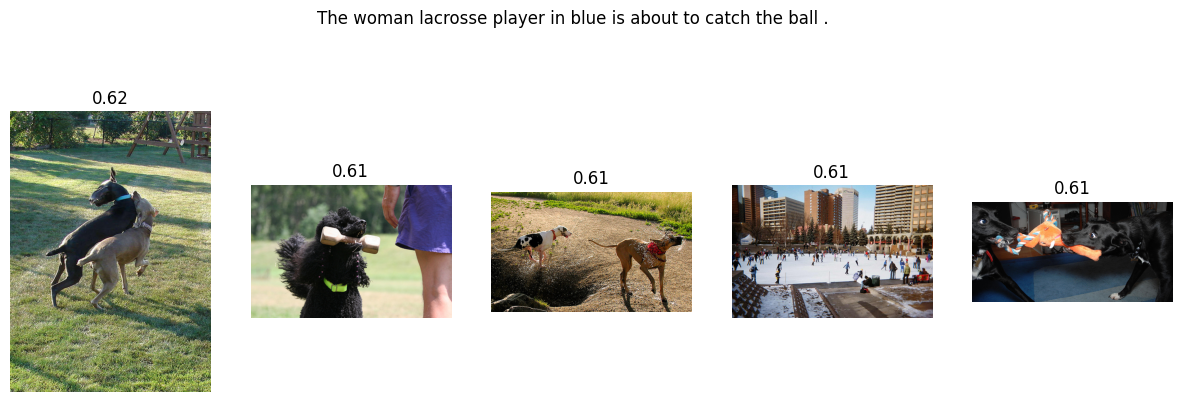


=== Query: A white dog with brown ears is running on the sidewalk . ===


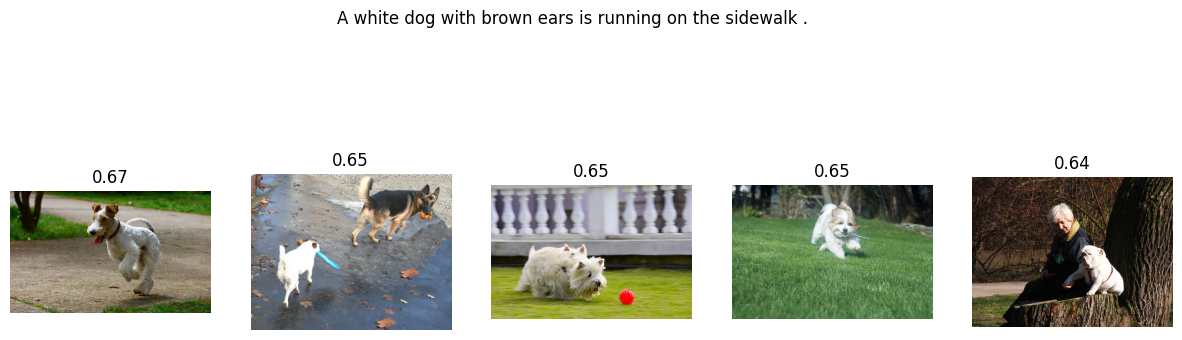


=== Query: Six spectators watching a dirt racing car pass by in a cloud of dust . ===


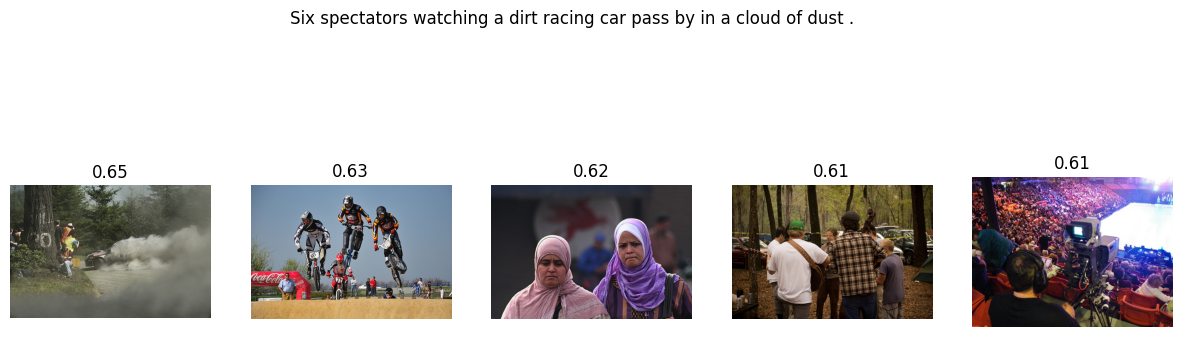


=== Query: Two men kickbox in a ring , one man punching the other . ===


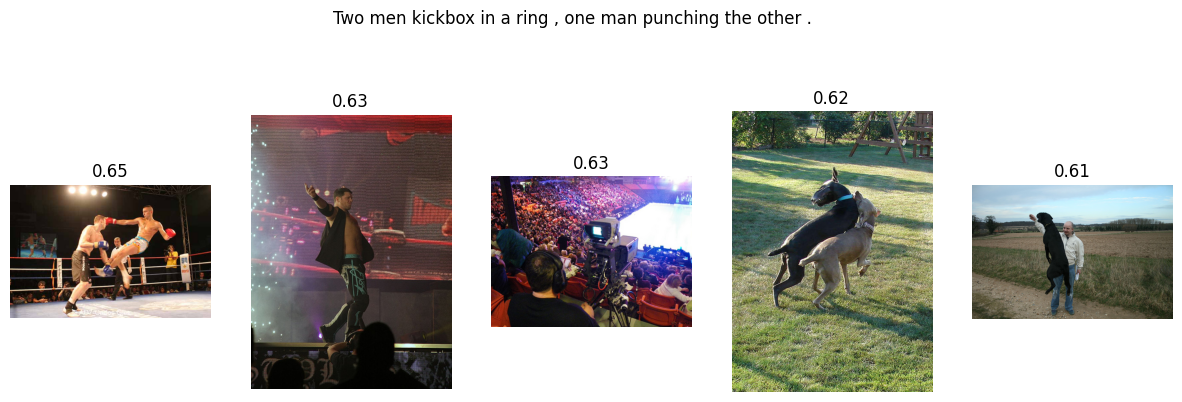


=== Query: A dog jumps to catch a red ball outside . ===


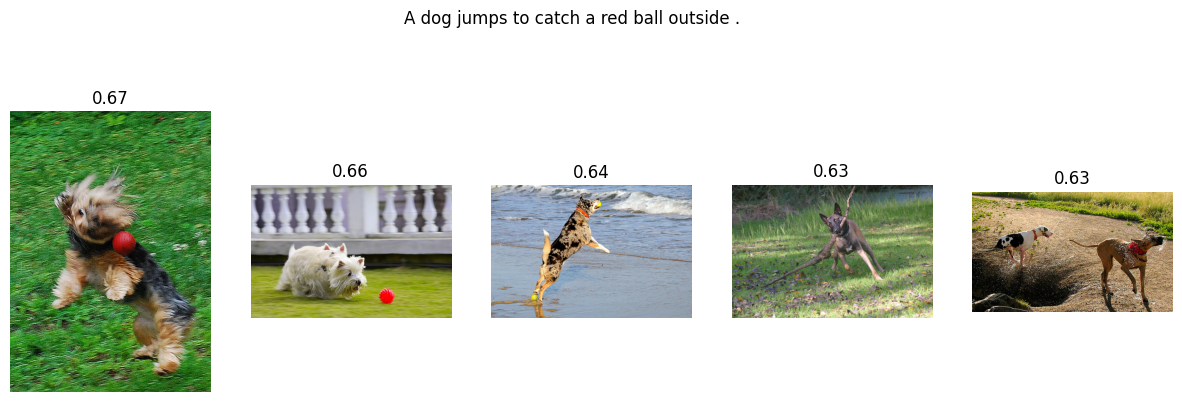


=== Query: A man on a waterski is performing a jump in the air . ===


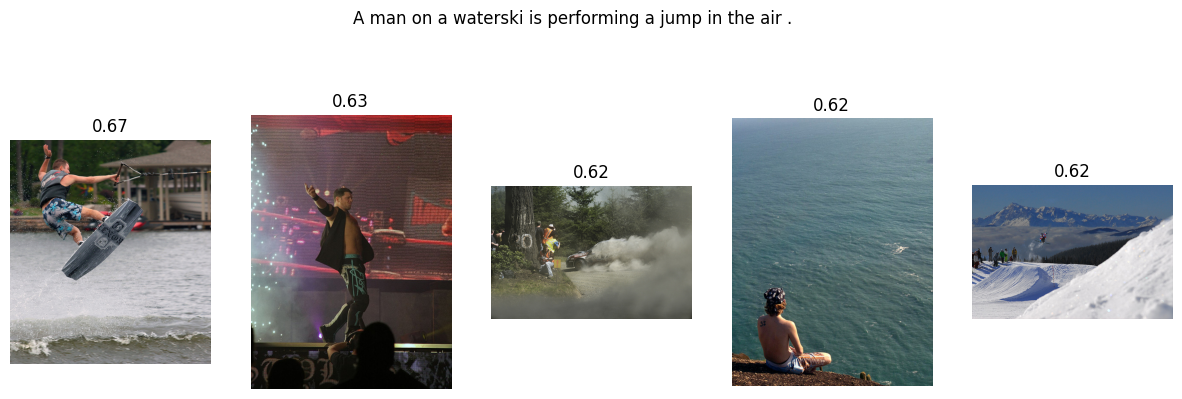


=== Query: Two small white dogs are in a yard chasing a red ball . ===


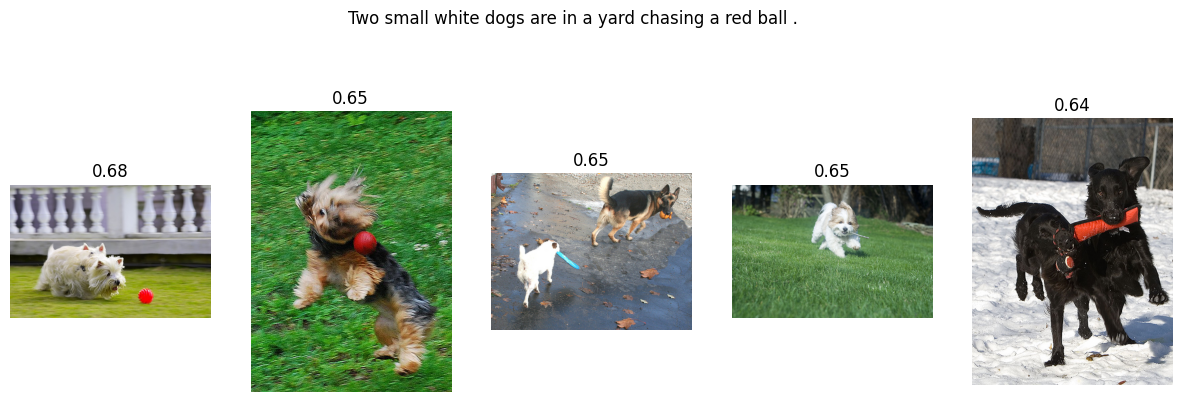


=== Query: A dog wearing jeans and a shirt stands on the sidewalk . ===


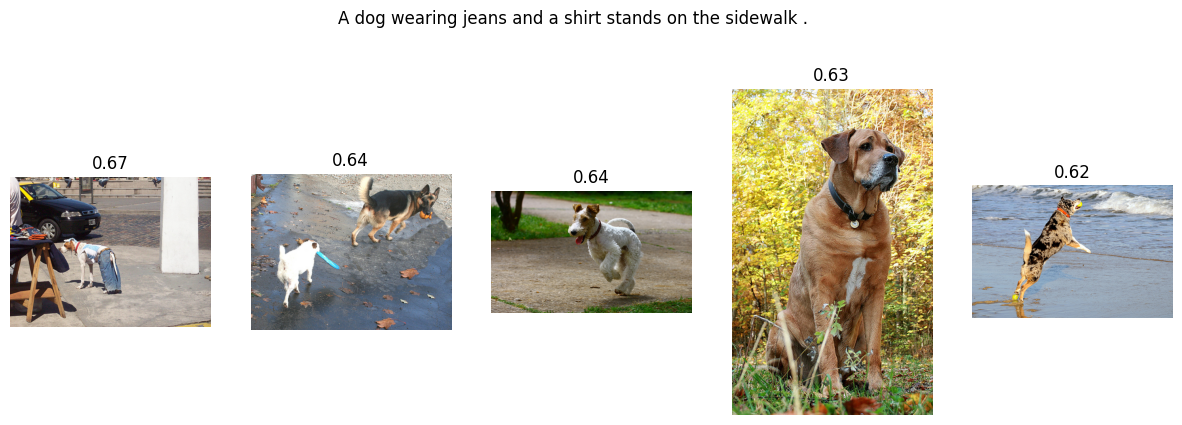


=== Query: A man , seen from the back , with his head turned to the side wearing a backpack ===


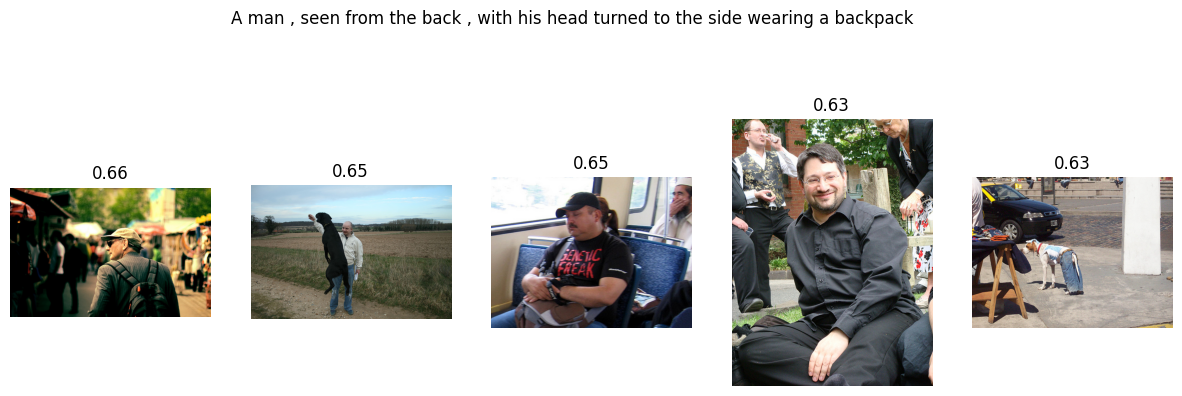


=== Query: The dog is sitting on the side of the hill . ===


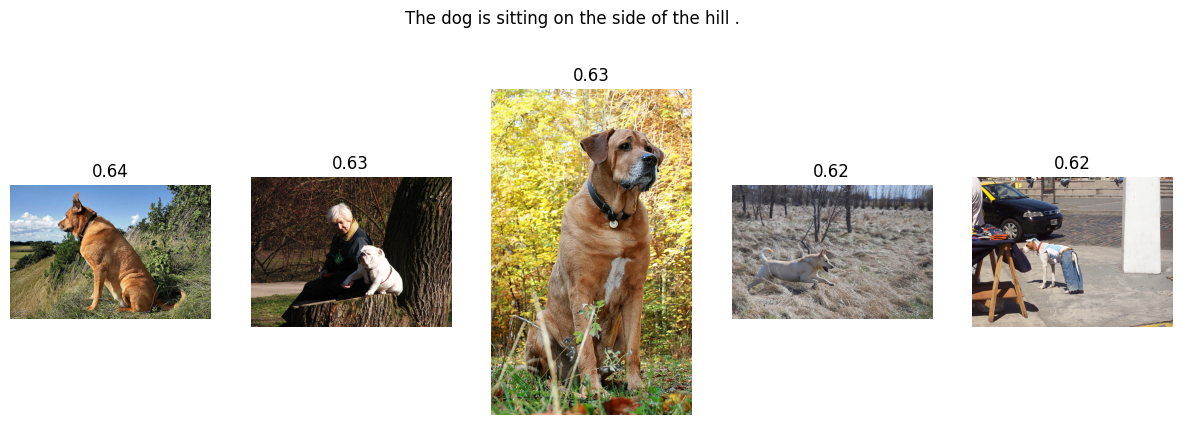

In [ ]:
sample_queries = test_queries_clean.sample(10)

for idx, row in sample_queries.iterrows():
    query_text = row['query_text']
    print(f"\n=== Query: {query_text} ===")
    show_results_mlp_test(query_text)

На тестовых запросах можно убедиться, что модель корректно предсказывает изображения для запросов.

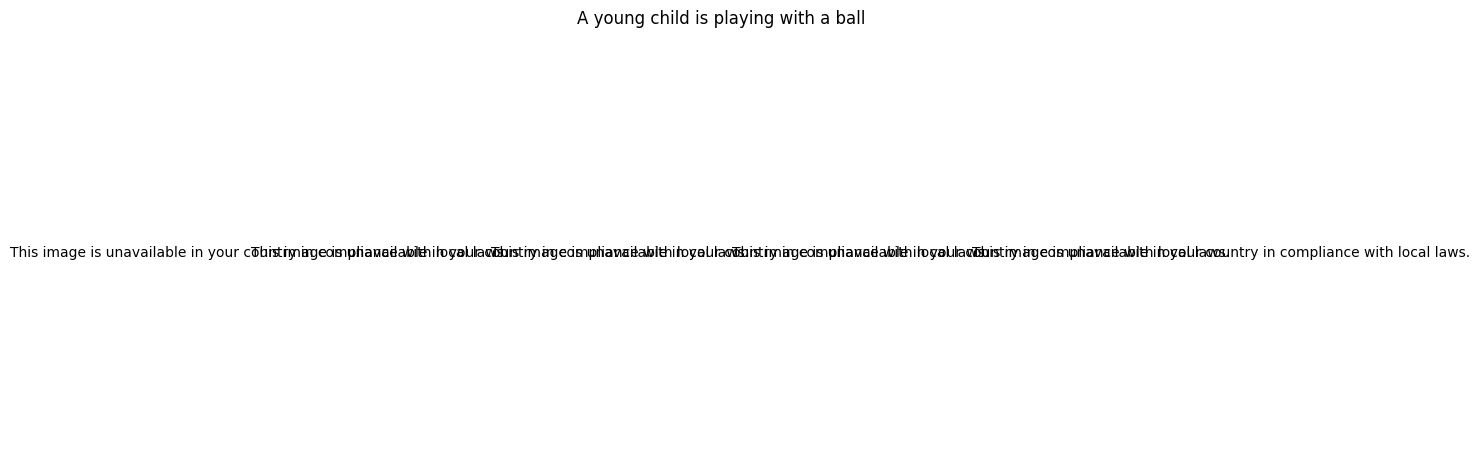

In [ ]:
test_query = "A young child is playing with a ball"
show_results_mlp_test(test_query)

Дисклеймер корректно срабатывает для запрещённых слов.

## Общий вывод

В ходе проекта была построена система поиска изображений по текстовым запросам с учётом модерации чувствительного контента. Основные этапы и результаты:

1. Обработка данных

- Объединили экспертные и краудсорсинговые оценки для получения метки combined_score.

- Осуществили нормализацию и подготовку признаков.

- Выявили и отфильтровали запрещённые запросы и соответствующие изображения, чтобы исключить потенциально неприемлемый контент.

2. Использование CLIP

- Получили эмбеддинги изображений и текста с помощью CLIPModel.

- Вычислили базовое сходство clip_sim, которое показало RMSE = 0.242 на трейне, демонстрируя базовую релевантность.

3. Модели для предсказания оценки релевантности

- Линейная регрессия на CLIP-эмбеддингах улучшила RMSE до 0.121.

- Полносвязная нейронная сеть (MLP), обученная на объединённых эмбеддингах изображений и текста, достигла RMSE = 0.111, что показало наилучшие результаты.

4. Тестирование и фильтрация

- Проверка на тестовых запросах показала корректный вывод релевантных изображений.

- Для запрещённых запросов система выводит дисклеймер: “This image is unavailable in your country in compliance with local laws.”.

- Дисклеймер и фильтрация запрещённого контента срабатывают надёжно.

Система успешно объединяет возможности CLIP и MLP для точного поиска изображений по тексту, одновременно обеспечивая безопасный вывод контента. Проект демонстрирует баланс между качеством предсказаний и соблюдением правил модерации, что делает его готовым для применения в реальных задачах поиска и рекомендаций изображений.